In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score,recall_score,precision_score
from explainerdashboard import ClassifierExplainer, ExplainerDashboard
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
plt.style.use('ggplot')

%matplotlib inline
matplotlib.rcParams['figure.figsize']=(12,8)


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`

The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`

The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you're using any of the table format helpers (e.g. Group), replace 
`from dash_table.Format import Group` with 
`from dash.dash_table.Format import Group`


In [2]:
feature_descriptions={'State':'Customer’s state',
'Account Length':'Integer number showing the duration of activity for customer account',
'Area Code':'Area code of customer',
'Phone':'Phone number of customer',
"Int'l Plan":'Binary indicator showing whether the customer has international calling plan',
'VMail Plan':'Indicator of voice mail plan',
'VMail Message':'The number of voicemail messages',
'Day Mins':'The number of minutes the customer used the service during day time',
'Day Calls':'Discrete attribute indicating the total number of calls during day time',
'Day Charge':'Charges for using the service during day time',
'Eve Mins':'The number of minutes the customer used the service during evening time',
'Eve Calls':' The number of calls during evening time',
'Eve Charge':' Charges for using the service during evening time',
'Night Mins':' Number of minutes the customer used the service during night time',
'Night Calls':'The number of calls during night time',
'Night Charge':'Charges for using the service during night time',
'Intl Mins':'Number of minutes the customer used the service to make international calls',
'Intl Calls':'The number of international calls',
'Intl Charge':'Charges for international calls',
'CustServ Calls':'The number of calls to customer support service'
}

# Import dataset

In [3]:
df=pd.read_csv('churn.csv')

# Data Transformation

### Transform phone and binary attributes

In [4]:
df['Phone_Number']='('+df['Area Code'].astype('str')+')'+df['Phone']
df["Int'l Plan"]=df["Int'l Plan"].apply(lambda i:0 if i=="no" else 1)
df['VMail Plan']=df['VMail Plan'].apply(lambda i:0 if i=="no" else 1)
df['Churn?']=df['Churn?'].apply(lambda c:0 if c=="False." else 1)

In [5]:
df.index=df['Phone_Number']
df=df.drop(columns=['Area Code','Phone','Phone_Number'])

### Divide into attributes and class

In [6]:
X=df.iloc[:,:-1]
y=df.iloc[:,-1]

### Encoding State column

In [7]:
X=pd.get_dummies(X,columns=['State'])

### Splitting the dataset into the Training set and Test set

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 0)

In [9]:
phone_numbers=X_test.index.tolist()

# Building model using Decision Tree

### Training the Decision Tree Classification model on the Training set

In [10]:
def decision_tree_class():
    classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
    classifier.fit(X_train, y_train)
    return classifier

In [11]:
dt_class=decision_tree_class()

In [12]:
def generate_dt_dashboard():
    explainer_dt_all = ClassifierExplainer(dt_class, X_test, y_test, 
                                    descriptions=feature_descriptions,
                                    labels=['Not Churn', 'Churn'], 
                                    cats=['State'],
                                    idxs = phone_numbers, 
                                    index_name = "Phone Number", 
                                    target = "Churn", 
                                    )
    db_dt_all=ExplainerDashboard(explainer_dt_all, 
                            title="Churn Prediction by Decision Tree", 
                            shap_interaction=False,
                            )
    db_dt_all.run(port=8050)

### Making the Confusion Matrix for Decision Tree

In [13]:
def cm_scores(classifier):
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp= confusion_matrix(y_test, y_pred).ravel()
    print(cm)
    print(' ')
    print('True Positive is {}.'.format(tp))
    print('True Negative is {}.'.format(tn))
    print('False Positive is {}.'.format(fp))
    print('False Negative is {}.\n'.format(fn))
    accuracy=round(accuracy_score(y_test, y_pred),2)
    recall=round(recall_score(y_test,y_pred),2)
    precision=round(precision_score(y_test,y_pred),2)
    print('Accuracy is {}.'.format(accuracy))
    print('Recall is {}.'.format(recall))
    print('Precision is {}.\n'.format(precision))
    return tn,fp,fn,tp,accuracy,recall,precision

In [14]:
dt_tn,dt_fp,dt_fn,dt_tp,dt_accuracy,dt_recall,dt_precision=cm_scores(dt_class)

[[1077   75]
 [  51  131]]
 
True Positive is 131.
True Negative is 1077.
False Positive is 75.
False Negative is 51.

Accuracy is 0.91.
Recall is 0.72.
Precision is 0.64.



### Visualize the importances of attributes

In [15]:
importance_dt=dt_class.feature_importances_

In [16]:
def get_importance(importance):
    import_df=pd.DataFrame(importance,index=X.columns)
    state_importance=0
    new_import_df=import_df.copy()
    for i in import_df.index.tolist():
        if 'State' in i:
            state_importance+=import_df[0][i]
            new_import_df=new_import_df.drop(i,axis=0)
    new_import_df=new_import_df.append(pd.DataFrame([state_importance],index=['State']))
    new_import_df=new_import_df.sort_values(by=0,ascending=False)
    ind=new_import_df.index.tolist()
    return ind,new_import_df

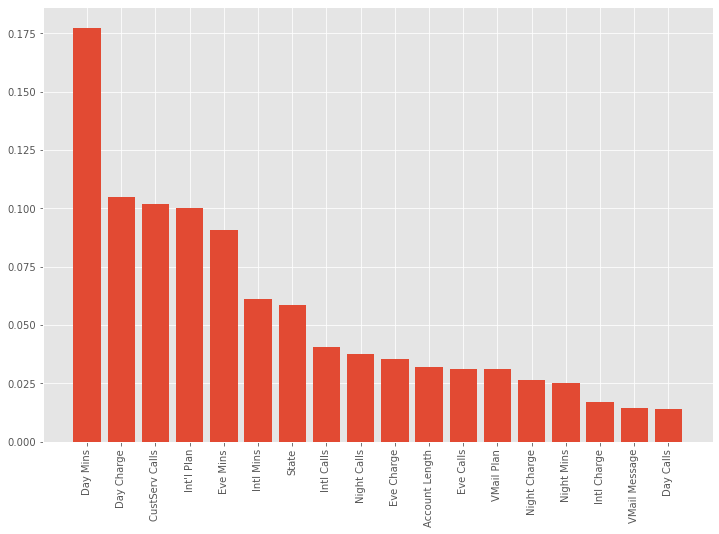

In [17]:
ind_dt,new_import_df_dt=get_importance(importance_dt)
plt.bar([x for x in range(len(new_import_df_dt))], new_import_df_dt[0])
plt.xticks([i for i in range(len(ind_dt))],ind_dt,rotation=90)
plt.show()

# Building model using Naive Bayes

### Training the Naive Bayes Classification model on the Training set

In [18]:
def naive_bayes_class():
    classifier = GaussianNB()
    classifier.fit(X_train, y_train)
    return classifier

In [19]:
nb_class=naive_bayes_class()

In [20]:
def generate_nb_dashboard():
    explainer_nb_all = ClassifierExplainer(nb_class, X_test, y_test, 
                                    descriptions=feature_descriptions,
                                    labels=['Not Churn', 'Churn'], 
                                    cats=['State'],
                                    idxs = phone_numbers, 
                                    index_name = "Phone Number", 
                                    target = "Churn", 
                                    )
    db_nb_all=ExplainerDashboard(explainer_nb_all, 
                            title="Churn Prediction by Naive Bayes", 
                            shap_interaction=False,
                            )
    db_nb_all.run(port=8050)

### Making the Confusion Matrix for Naive Bayes

In [21]:
nb_tn,nb_fp,nb_fn,nb_tp,nb_accuracy,nb_recall,nb_precision=cm_scores(nb_class)

[[643 509]
 [ 68 114]]
 
True Positive is 114.
True Negative is 643.
False Positive is 509.
False Negative is 68.

Accuracy is 0.57.
Recall is 0.63.
Precision is 0.18.



### Visualize the importances of attributes

In [22]:
from sklearn.inspection import permutation_importance

In [23]:
imps = permutation_importance(nb_class, X_test, y_test)
importance_nb=imps.importances_mean

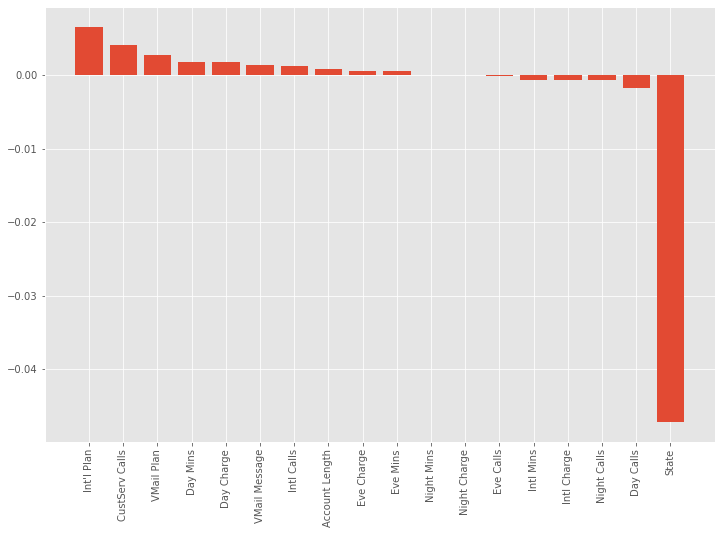

In [24]:
ind_nb,new_import_df_nb=get_importance(importance_nb)
plt.bar([x for x in range(len(new_import_df_nb))], new_import_df_nb[0])
plt.xticks([i for i in range(len(ind_nb))],ind_nb,rotation=90)
plt.show()

# Confusion Matrix Comparison 

In [25]:
cm_compare=pd.DataFrame([[dt_tp,dt_fn,nb_tp,nb_fn],[dt_fp,dt_tn,nb_fp,nb_tn],[dt_accuracy,np.nan,nb_accuracy,np.nan],[dt_recall,np.nan,nb_recall,np.nan],[dt_precision,np.nan,nb_precision,np.nan]],
                        index=pd.Index(['Churn','Not Churn','Accuracy','Recall','Precision'],name='Actual:'),
                        columns=pd.MultiIndex.from_product([['Decision Tree','Naive Bayes'],['Churn','Not Churn']],names=['Model:','Predicted']))
cm_compare=cm_compare.style.format('{:.2f}')

In [26]:
cell_hover = {
    'selector': 'td:hover',
    'props': [('background-color', '#ffffb3')]
}
index_names = {
    'selector': '.index_name',
    'props': [('font-style','italic'), ('color', 'darkgrey'), ('font-weight','normal')]
}
headers = {
    'selector': 'th:not(.index_name)',
    'props': [('background-color','#000066'), ('color','white')]
}


In [27]:
cm_compare=cm_compare.set_table_styles([cell_hover, index_names, headers])

In [28]:
cm_compare=cm_compare.set_table_styles([
    {'selector': 'th.col_heading', 'props': [('text-align', 'center')]},
    {'selector': 'th.col_heading.level0', 'props': [('font-size', '1.5em')]},
    {'selector': 'td', 'props': [('text-align','center'), ('font-weight', 'bold')]}
], overwrite=False)

In [29]:
cm_compare=cm_compare.set_table_styles({
    ('Naive Bayes', 'Churn'): [{'selector': 'th', 'props': [('border-left','1px solid white')]},
                               {'selector': 'td', 'props': [('border-left','1px solid #000066')]}]
}, overwrite=False, axis=0)

In [30]:
cm_compare

# Find which attributes to build models

### Decision Tree

In [31]:
def visual_metrics(model,import_df):
    train_accuracies=[]
    test_accuracies=[]
    train_precisions=[]
    test_precisions=[]
    use_cols=[]
    features=import_df.index.tolist()
    for i in range(len(features),0,-1):
        use_features=features[:i]
        use_cols.append(len(use_features))
        X=df[use_features]
        if 'State' in use_features:
            X=pd.get_dummies(X,columns=['State'])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 0)
        if model=='Decision Tree':
            classifier=DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
        else:
            classifier=GaussianNB()
        classifier.fit(X_train,y_train)
        train_accuracies.append(accuracy_score(y_train,classifier.predict(X_train)))
        test_accuracies.append(accuracy_score(y_test,classifier.predict(X_test)))
        train_precisions.append(precision_score(y_train,classifier.predict(X_train)))
        test_precisions.append(precision_score(y_test,classifier.predict(X_test)))
    fig,(ax1,ax2)=plt.subplots(2)
    ax1.plot(use_cols,train_accuracies,'-o',label='Train')
    ax1.plot(use_cols,test_accuracies,'-o',label='Test')
    ax1.legend()
    ax1.invert_xaxis()
    ax1_y_max=max(test_accuracies)
    ax1_x=use_cols[test_accuracies.index(ax1_y_max)]
    ax1.annotate('Highest Accuracy ({} features used)'.format(ax1_x),xy=(ax1_x,ax1_y_max),xytext=(ax1_x, ax1_y_max+0.03),arrowprops=dict(facecolor='black', shrink=0.05))
    ax1.set_title('Accuracy of {}'.format(model))
    
    ax2.plot(use_cols,train_precisions,'-o',label='Train')
    ax2.plot(use_cols,test_precisions,'-o',label='Test')
    ax2.legend()
    ax2.invert_xaxis()
    ax2_y_max=max(test_precisions)
    ax2_x=use_cols[test_precisions.index(ax2_y_max)]
    ax2.annotate('Highest Precision ({} features used)'.format(ax2_x),xy=(ax2_x,ax2_y_max),xytext=(ax2_x, ax2_y_max+0.03),arrowprops=dict(facecolor='black', shrink=0.05))
    ax2.set_title('Precision of {}'.format(model))
    fig.show()

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


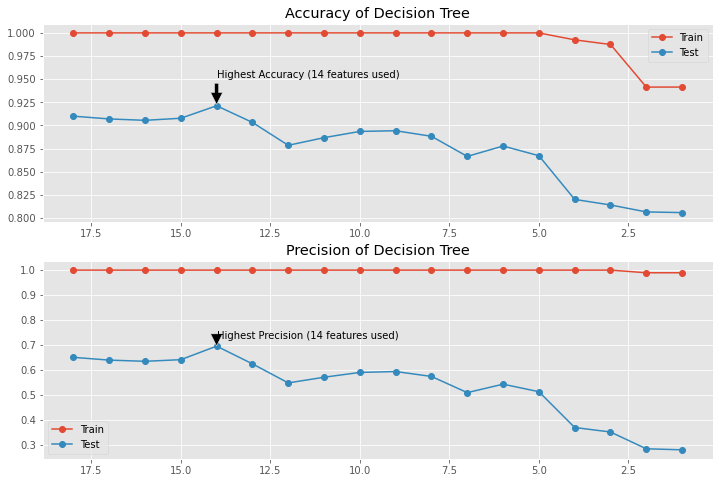

In [32]:
visual_metrics('Decision Tree',new_import_df_dt)

### Naive Bayes

In [33]:
import_nb=new_import_df_nb.apply(lambda x:abs(x))
import_nb=import_nb.sort_values(by=0,ascending=False)

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


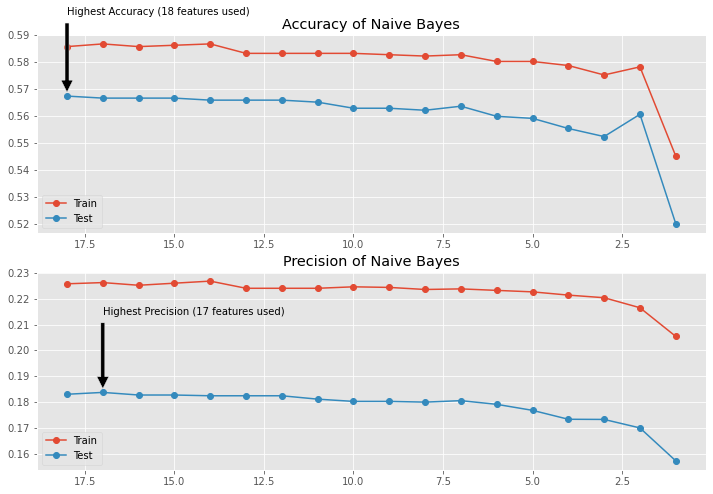

In [34]:
visual_metrics('Naive Bayes',import_nb)

# Building models using filtered attributes

### Decision Tree

In [35]:
filtered_att_dt=new_import_df_dt.index.tolist()[:14]
print('Using the following attributes to build a new model:\n')
for i,att in enumerate(filtered_att_dt):
    print('{}. {}'.format(i+1,att))

Using the following attributes to build a new model:

1. Day Mins
2. Day Charge
3. CustServ Calls
4. Int'l Plan
5. Eve Mins
6. Intl Mins
7. State
8. Intl Calls
9. Night Calls
10. Eve Charge
11. Account Length
12. Eve Calls
13. VMail Plan
14. Night Charge


In [36]:
def filtered_att_pred(model,filtered_att):
    X_filtered=df[filtered_att]
    X_filtered=pd.get_dummies(X_filtered,columns=['State'])
    X_train_filtered,X_test_filtered,y_train_filtered,y_test_filtered=train_test_split(X_filtered,y,test_size=0.4,random_state=0)
    if model=='Decision Tree':
        filtered_class=DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
    else:
        filtered_class=GaussianNB()
    filtered_class.fit(X_train_filtered,y_train_filtered)
    
    y_pred_filtered = filtered_class.predict(X_test_filtered)
    cm = confusion_matrix(y_test_filtered, y_pred_filtered)
    tn, fp, fn, tp= confusion_matrix(y_test_filtered, y_pred_filtered).ravel()
    print(cm)
    print(' ')
    print('True Positive is {}.'.format(tp))
    print('True Negative is {}.'.format(tn))
    print('False Positive is {}.'.format(fp))
    print('False Negative is {}.\n'.format(fn))
    accuracy=round(accuracy_score(y_test_filtered, y_pred_filtered),2)
    recall=round(recall_score(y_test_filtered, y_pred_filtered),2)
    precision=round(precision_score(y_test_filtered, y_pred_filtered),2)
    print('Accuracy is {}.'.format(accuracy))
    print('Recall is {}.'.format(recall))
    print('Precision is {}.\n'.format(precision))
    return tn,fp,fn,tp,accuracy,recall,precision

In [37]:
dt_tn_filtered,dt_fp_filtered,dt_fn_filtered,dt_tp_filtered,dt_accuracy_filtered,dt_recall_filtered,dt_precision_filtered=filtered_att_pred('Decision Tree',filtered_att_dt)

[[1092   60]
 [  45  137]]
 
True Positive is 137.
True Negative is 1092.
False Positive is 60.
False Negative is 45.

Accuracy is 0.92.
Recall is 0.75.
Precision is 0.7.



### Naive Bayes

In [38]:
filtered_att_nb=import_nb.index.tolist()[:17]
print('Using the following attributes to build a new model:\n')
for i,att in enumerate(filtered_att_nb):
    print('{}. {}'.format(i+1,att))

Using the following attributes to build a new model:

1. State
2. Int'l Plan
3. CustServ Calls
4. VMail Plan
5. Day Mins
6. Day Charge
7. Day Calls
8. VMail Message
9. Intl Calls
10. Account Length
11. Eve Charge
12. Eve Mins
13. Night Calls
14. Intl Mins
15. Intl Charge
16. Eve Calls
17. Night Mins


In [39]:
nb_tn_filtered,nb_fp_filtered,nb_fn_filtered,nb_tp_filtered,nb_accuracy_filtered,nb_recall_filtered,nb_precision_filtered=filtered_att_pred('Naive Bayes',filtered_att_nb)

[[641 511]
 [ 67 115]]
 
True Positive is 115.
True Negative is 641.
False Positive is 511.
False Negative is 67.

Accuracy is 0.57.
Recall is 0.63.
Precision is 0.18.



# Confusion Matrix Comparison

In [40]:
cm_compare2=pd.DataFrame([[dt_tp,dt_fn,dt_tp_filtered,dt_fn_filtered,nb_tp,nb_fn,nb_tp_filtered,nb_fn_filtered],
                          [dt_fp,dt_tn,dt_fp_filtered,dt_tn_filtered,nb_fp,nb_tn,nb_fp_filtered,nb_tn_filtered],
                          [dt_accuracy,np.nan,dt_accuracy_filtered,np.nan,nb_accuracy,np.nan,nb_accuracy_filtered,np.nan],
                          [dt_recall,np.nan,dt_recall_filtered,np.nan,nb_recall,np.nan,nb_recall_filtered,np.nan],
                          [dt_precision,np.nan,dt_precision_filtered,np.nan,nb_precision,np.nan,nb_precision_filtered,np.nan]],
                        index=pd.Index(['Churn','Not Churn','Accuracy','Recall','Precision'],name='Actual:'),
                        columns=pd.MultiIndex.from_product([['Decision Tree','Decision Tree (filtered)','Naive Bayes','Naive Bayes (filtered)'],['Churn','Not Churn']],names=['Model:','Predicted']))
cm_compare2=cm_compare2.style.format('{:.2f}')

In [41]:
cm_compare2=cm_compare2.set_table_styles([cell_hover, index_names, headers])
cm_compare2=cm_compare2.set_table_styles([
    {'selector': 'th.col_heading', 'props': [('text-align', 'center')]},
    {'selector': 'th.col_heading.level0', 'props': [('font-size', '1.5em')]},
    {'selector': 'td', 'props': [('text-align','center'), ('font-weight', 'bold')]}
], overwrite=False)
cm_compare2=cm_compare2.set_table_styles({
    ('Naive Bayes', 'Churn'): [{'selector': 'th', 'props': [('border-left','1px solid white')]},
                               {'selector': 'td', 'props': [('border-left','1px solid #000066')]}]
}, overwrite=False, axis=0)

In [42]:
cm_compare2